# DCIP Complex geology

Using PGI regularization with Gaussian mixture random markov field model and SAM segmentation lets try more complex geology

In [4]:
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as DCUtils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)


def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The Intersection over Union (IoU) score.
    """
    
    # Ensure the masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Mask shapes do not match.")

    # Convert masks to binary (0 or 1) values
    mask1 = np.array(mask1 > 0, dtype=np.uint8)
    mask2 = np.array(mask2 > 0, dtype=np.uint8)

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    iou = intersection / union if union > 0 else 0.0
    return iou


class GaussianMixtureMarkovRandomField(utils.WeightedGaussianMixture):

    def __init__(
        self,
        n_components,
        mesh,
        actv=None,
        kdtree=None,
        indexneighbors=None,
        boreholeidx=None,
        T=12.,
        masks=None,
        kneighbors=0,
        norm=2,
        init_params='kmeans',
        max_iter=100,
        covariance_type='full',
        means_init=None,
        n_init=10, 
        precisions_init=None,
        random_state=None, 
        reg_covar=1e-06, 
        tol=0.001, 
        verbose=0,
        verbose_interval=10, 
        warm_start=False, 
        weights_init=None,
        anisotropy=None,
        index_anisotropy=None, # Dictionary with anisotropy and index
        index_kdtree=None,# List of KDtree
        segmentation_model_checkpoint=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth",
        #**kwargs
    ):

        super(GaussianMixtureMarkovRandomField, self).__init__(
            n_components=n_components,
            mesh=mesh,
            actv=actv,
            covariance_type=covariance_type,
            init_params=init_params,
            max_iter=max_iter,
            means_init=means_init,
            n_init=n_init,
            precisions_init=precisions_init,
            random_state=random_state,
            reg_covar=reg_covar,
            tol=tol,
            verbose=verbose,
            verbose_interval=verbose_interval,
            warm_start=warm_start,
            weights_init=weights_init,
            #boreholeidx=boreholeidx
            # **kwargs
        )
        # setKwargs(self, **kwargs)
        self.kneighbors = kneighbors
        self.T = T
        self.boreholeidx = boreholeidx
        self.anisotropy = anisotropy
        self.norm = norm
        self.masks = masks
        self.mask_assignment = None
        self.segmentation_model_checkpoint = segmentation_model_checkpoint

        # load segmentation network model
        sam = sam_model_registry["vit_h"](checkpoint=self.segmentation_model_checkpoint)
        self.mask_generator = SamAutomaticMaskGenerator(sam)

        if self.mesh.gridCC.ndim == 1:
            xyz = np.c_[self.mesh.gridCC]
        elif self.anisotropy is not None:
            xyz = self.anisotropy.dot(self.mesh.gridCC.T).T
        else:
            xyz = self.mesh.gridCC
        
        if self.actv is None:
            self.xyz = xyz
        else:
            self.xyz = xyz[self.actv]
        
        if kdtree is None:
            print('Computing KDTree, it may take several minutes.')
            self.kdtree = spatial.KDTree(self.xyz)
        else:
            self.kdtree = kdtree
        
        if indexneighbors is None:
            print('Computing neighbors, it may take several minutes.')
            _, self.indexneighbors = self.kdtree.query(self.xyz, k=self.kneighbors+1, p=self.norm)
        else:
            self.indexneighbors = indexneighbors

        self.indexpoint = copy.deepcopy(self.indexneighbors)
        self.index_anisotropy = index_anisotropy
        self.index_kdtree = index_kdtree
        if self.index_anisotropy is not None and self.mesh.gridCC.ndim != 1:

            self.unitxyz = []
            for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                self.unitxyz.append((anis).dot(self.xyz.T).T)

            if self.index_kdtree is None:
                self.index_kdtree = []
                print('Computing rock unit specific KDTree, it may take several minutes.')
                for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                    self.index_kdtree.append(spatial.KDTree(self.unitxyz[i]))

            #print('Computing new neighbors based on rock units, it may take several minutes.')
            #for i, unitindex in enumerate(self.index_anisotropy['index']):
        #        _, self.indexpoint[unitindex] = self.index_kdtree[i].query(self.unitxyz[i][unitindex], k=self.kneighbors+1)

    def update_neighbors_index(
            
            self,
            model:np.ndarray
            
    ) -> None:
        """
        
            method that segments the input model and assigns new neighbors described
            by the segmentation map

            :param model: geophysical model
            :type model: np.ndarray

        """

        model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

        image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(self.mesh.shape_cells, order='F'))*255))
        image_rgb = image_rgb.convert('RGB')

        result = self.mask_generator.generate(np.asarray(image_rgb))


        # ---------------------------------------------------------------------------------------------

        # create a matrix that holds information about overlapping mask if they happen to

        # this is done using intersection over union method

        #

        nlayers = len(result)

        union_matrix = np.zeros((nlayers, nlayers))
        for ii in range(nlayers):
            for jj in range(nlayers):
                iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
                union_matrix[ii, jj] = iou_score
                # print("IoU score:", iou_score)

        # ------------------------------------------------------------------------------------

        # modify the overlap matrix to assign the proper neighbors mask in the case of onions

        #

        sub_union_matrix = union_matrix[1:, 1:].copy()
        # print(f"before sub-union: {sub_union_matrix}\n\n")

        removal = []

        # check if masks have to be removed
        for jj in range(sub_union_matrix.shape[0]):
            
            if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                
                if mask_index[0].shape[0] == sub_union_matrix.shape[1]:
                    print("\n\n removal\n\n")
                    removal.append(jj)

        if len(removal) > 0:

            for indx in removal:

                result.pop(indx + 1)
                sub_union_matrix = np.delete(sub_union_matrix, indx, 0)
                sub_union_matrix = np.delete(sub_union_matrix, indx, 1)

        # print(f"modified sub-union: {sub_union_matrix}\n\n")

        # calculate how many non zero in a row of our overlap matrix
        for jj in range(sub_union_matrix.shape[0]):

            if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                # print(mask_index[0][-1])
                sub_union_matrix[jj, mask_index[0][-1]] = 1
                sub_union_matrix[jj, mask_index[0][0]] = 0

        # print(f"sub-union: {sub_union_matrix}\n\n")
        # --------------------------------------------------------------------------------------

        # assign each cell a mask to assign it's neighbors

        #

        nlayers = len(result)

        hx, hy = self.mesh.shape_cells
        x = np.arange(hx)
        y = np.arange(hy)
        xx, yy = np.meshgrid(x, y)

        mask_locations = np.vstack([xx.flatten(), yy.flatten()])

        mask_assignment = np.zeros(mask_locations.shape[1])

        for ii in range(mask_locations.shape[1]):

            for jj in range(nlayers - 1):

                idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

                point_set = idx.T

                # print(point_set.shape, np.vstack(idx).shape, xx.shape)
                distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
                # print(jj, mask_assignment[:, ii].T, point_set[0, :])
                min_distance = np.min(distances)
                
                if min_distance == 0:

                    # find which mask to assign
                    idx1 = np.nonzero(sub_union_matrix[jj, :])
                    mask_assignment[ii] = idx1[0][0] + 1

        # plt.hist(mask_assignment, 100)
        # plt.show()
        # ----------------------------------------------------------------------------------------

        # now update the indexpoint matrix

        #

        for kk in range(mask_assignment.shape[0]):

            # check union matrix for the correct mask
            union_index = int(mask_assignment[kk])
            # print(union_index, sub_union_matrix.shape)
            if union_index < 0:

                pass

            else:
                # print(sub_union_matrix[union_index, :])
                mask_select = union_index

                idx = np.vstack(np.where(result[mask_select]['segmentation'].flatten(order='F') == True))[0]
                shape_idx = idx.shape[0]

                # if the mask is smaller than the user defined number of neighbors
                if idx.shape[0] < (self.kneighbors + 1):

                    self.indexpoint[kk, :] = self.indexpoint[kk, 0]
                    self.indexpoint[kk, -shape_idx:] = idx

                # otherwise assign the entire mask
                else:

                    # print(f"idx shape: {idx.shape} knei: {self.kneighbors} {shape_idx} {self.indexpoint.shape} {kk}")
                    # print(idx[:(self.kneighbors + 1)].shape, mask_locations.shape, mask_assignment.shape)
                    self.indexpoint[kk, :] = idx[:(self.kneighbors + 1)]

        self.masks = result
        self.sub_union_matrix = sub_union_matrix
        # print(np.bincount(onion.flatten()))

        # fig, ax = plt.subplots(3,2, figsize=(10, 10))
        # result[0].keys()
        # ax[0, 0].imshow(np.log(model.reshape(self.mesh.shape_cells, order='F')).T)
        # ax[0, 0].invert_yaxis()
        # ax[0, 0].set_title('PGI recovered model')

        # # for i in range(4):
        # ax[0, 1].imshow(result[1]['segmentation'].T)
        # ax[0, 1].invert_yaxis()
        # ax[0, 1].set_title('SAM segmentation item 1')
        # ax[1, 0].imshow(result[2]['segmentation'].T)
        # ax[1, 0].invert_yaxis()
        # ax[1, 0].set_title('SAM segmentation item 2')
        # ax[1, 1].imshow(result[3]['segmentation'].T)
        # ax[1, 1].invert_yaxis()
        # ax[1, 1].set_title('SAM segmentation item 3')
        # ax[2, 0].imshow(result[0]['segmentation'].T)
        # ax[2, 0].invert_yaxis()
        # ax[2, 0].set_title('SAM segmentation item 0')
        # # ax[2, 1].imshow(result[4]['segmentation'].T)
        # # ax[2, 1].invert_yaxis()
        # # ax[2, 1].set_title('SAM segmentation item 0')
        # plt.tight_layout()
        # plt.show()


    def predict(self, model):

        # output quasi-geological model
        geological_model = np.zeros(model.shape, dtype=int)

        # loop through and take mean value of the assigned 
        for ii in range(model.shape[0]):

            value = model[self.indexpoint[ii, :]].mean()
            idx = (np.abs(self.means_ - value)).argmin()
            geological_model[ii] = idx  # self.means_[idx]
            # print(f"assigning value: {geological_model[ii]}")

        return geological_model     
    
    def computeG(self, z, w, X):

        #Find neighbors given the current state of data and model
        if self.index_anisotropy is not None and self.mesh.gridCC.ndim != 1:
            prediction = self.predict(X)
            unit_index = []
            for i in range(self.n_components):
                unit_index.append(np.where(prediction==i)[0])
            for i, unitindex in enumerate(unit_index):
                _, self.indexpoint[unitindex] = self.index_kdtree[i].query(
                    self.unitxyz[i][unitindex],
                    k=self.kneighbors+1,
                    p=self.index_anisotropy['norm'][i]
                )

        logG = (self.T/(2.*(self.kneighbors+1))) * (
            (z[self.indexpoint] + w[self.indexpoint]).sum(
                axis=1
            )
        )
        # print(logG.shape, z[self.indexpoint], w[self.indexpoint], self.T, self.kneighbors)
        # plt.plot(logG.flatten(), '.')
        # plt.show()
        return logG

    def _m_step(self, X, log_resp):
        """M step.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        log_resp : array-like, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        n_samples, _ = X.shape
        _, self.means_, self.covariances_ = (
            self._estimate_gaussian_parameters(X, self.mesh, np.exp(log_resp), self.reg_covar,self.covariance_type)
        )
        #self.weights_ /= n_samples
        self.precisions_cholesky_ = _compute_precision_cholesky(
            self.covariances_, self.covariance_type)

        logweights = logsumexp(np.c_[[log_resp, self.computeG(np.exp(log_resp), self.weights_,X)]], axis=0)
        logweights = logweights - logsumexp(
            logweights, axis=1, keepdims=True
        )

        self.weights_ = np.exp(logweights)
        if self.boreholeidx is not None:
            aux = np.zeros((self.boreholeidx.shape[0],self.n_components))
            aux[np.arange(len(aux)), self.boreholeidx[:,1]]=1
            self.weights_[self.boreholeidx[:,0]] = aux


    def _check_weights(self, weights, n_components, n_samples):
        """Check the user provided 'weights'.
        Parameters
        ----------
        weights : array-like, shape (n_components,)
            The proportions of components of each mixture.
        n_components : int
            Number of components.
        Returns
        -------
        weights : array, shape (n_components,)
        """
        weights = check_array(
            weights, dtype=[np.float64, np.float32],
            ensure_2d=True
        )
        _check_shape(weights, (n_components, n_samples), 'weights')

    def _check_parameters(self, X):
        """Check the Gaussian mixture parameters are well defined."""
        n_samples, n_features = X.shape
        if self.covariance_type not in ['spherical', 'tied', 'diag', 'full']:
            raise ValueError("Invalid value for 'covariance_type': %s "
                             "'covariance_type' should be in "
                             "['spherical', 'tied', 'diag', 'full']"
                             % self.covariance_type)

        if self.weights_init is not None:
            self.weights_init = self._check_weights(
                self.weights_init,
                n_samples,
                self.n_components
            )

        if self.means_init is not None:
            self.means_init = _check_means(self.means_init,
                                           self.n_components, n_features)

        if self.precisions_init is not None:
            self.precisions_init = _check_precisions(self.precisions_init,
                                                     self.covariance_type,
                                                     self.n_components,
                                                     n_features)

    def _initialize(self, X, resp):
        """Initialization of the Gaussian mixture parameters.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        resp : array-like, shape (n_samples, n_components)
        """
        n_samples, _ = X.shape

        weights, means, covariances = self._estimate_gaussian_parameters(
            X, self.mesh, resp, self.reg_covar, self.covariance_type)
        weights /= n_samples

        self.weights_ = (weights*np.ones((n_samples,self.n_components)) if self.weights_init is None
                         else self.weights_init)
        self.means_ = means if self.means_init is None else self.means_init

        if self.precisions_init is None:
            self.covariances_ = covariances
            self.precisions_cholesky_ = _compute_precision_cholesky(
                covariances, self.covariance_type)
        elif self.covariance_type == 'full':
            self.precisions_cholesky_ = np.array(
                [linalg.cholesky(prec_init, lower=True)
                 for prec_init in self.precisions_init])
        elif self.covariance_type == 'tied':
            self.precisions_cholesky_ = linalg.cholesky(self.precisions_init,
                                                        lower=True)
        else:
            self.precisions_cholesky_ = self.precisions_init

3.11.3 (main, Apr 19 2023, 23:54:32) [GCC 11.2.0]



  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/utils/code_utils.py:264: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/mixins/mpl_mod.py:305: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


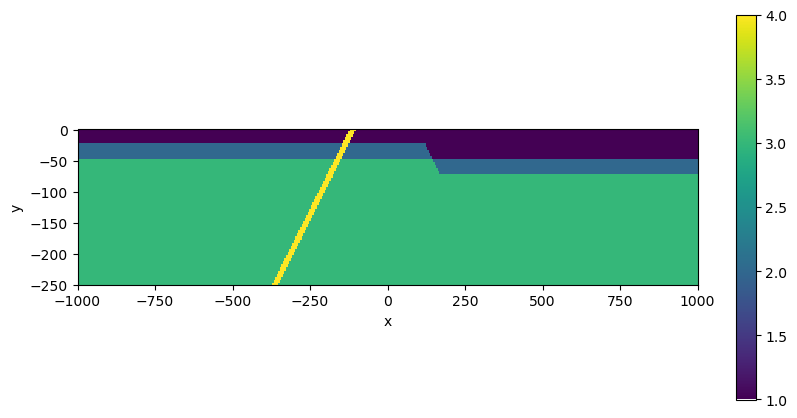

/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/utils/code_utils.py:755: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)



  TensorMesh: 9,381 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    159       -397.50        397.50      5.00      5.00    1.00
   y     59       -297.50         -2.50      5.00      5.00    1.00




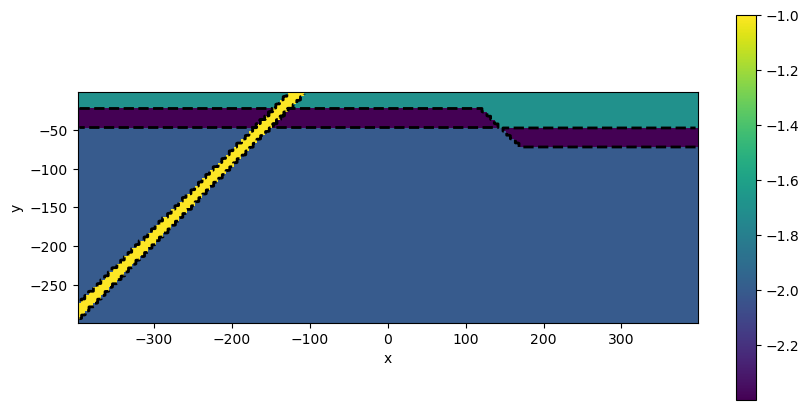

In [5]:
# -----------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift
domain = np.ones(mesh.nC, dtype='int64')
domain0 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],-1,100.)
domain[domain0] = 0

# Layered Earth
layered_model0 = 3 * np.ones(mesh.nC, dtype='int64')
layered_model0[mesh.gridCC[:,1]>-50] = 2
layered_model0[mesh.gridCC[:,1]>-25] = 1

layered_model1 = 3 * np.ones(mesh.nC, dtype='int64')
layered_model1[mesh.gridCC[:,1]>-75] = 2
layered_model1[mesh.gridCC[:,1]>-50] = 1

model = layered_model1
model[domain0] = layered_model0[domain0]

# Dike 45*
dike0 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 100)
dike1 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 125)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(1,1,figsize=(10,5))
mm = mesh.plotImage(model, ax=ax, pcolorOpts={'cmap':'viridis'})

plt.gca().set_xlim([-1000,1000])
plt.gca().set_ylim([-250,0])
plt.gca().set_aspect(2)
plt.colorbar(mm[0])

plt.show()

# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==1]= 50
res_true[model==2]= 250
res_true[model==3]= 100
res_true[model==4]= 10

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)
print(meshCore)

# plot
fig,ax = plt.subplots(1,1,figsize=(10,5))
mm = meshCore.plotImage(
    
    np.log10(cond_true)[actcore],
    ax=ax,
    pcolorOpts={'cmap':'viridis'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
plt.gca().set_aspect(1)
plt.colorbar(mm[0])
plt.show()

In [10]:
# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = dc.Survey(survey1.source_list + survey2.source_list)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(1e8)
)
mapping = expmap * mapactive
sim = dc.Simulation2DNodal(
    mesh,
    survey,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)


std = 0.02
# survey.dpred(mtrue[actcore])
dpred = sim.make_synthetic_data(mtrue[actcore], relative_error=std, force=True)
survey.eps = 1e-6

m0 = -np.log(np.median((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))) * np.ones(mapping.nP)

In [11]:
# Setup the inversion proceedure
# Define a counter
# Data misfit
dmis = data_misfit.L2DataMisfit(data=dpred, simulation=sim)
# Regularization
regmap = maps.IdentityMap(nP=int(actcore.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

reg = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=regmap,
    reference_model=m0
)
reg.alpha_s = 1/csx**2
reg.alpha_x = 100
reg.alpha_y = 100
reg.alpha_z = 100

# Optimization object
opt = optimization.ProjectedGNCG(maxIter=10, lower=-10, upper=10,
                                 maxIterLS=20, maxIterCG=100, tolCG=1e-5)

opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg,  opt)
invProb.beta = 1e2

# Inversion directives
Target = directives.TargetMisfit()
betaSched = directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
updateSensW = directives.UpdateSensitivityWeights(threshold=1e-6,everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
inv = inversion.BaseInversion(invProb,  directiveList=[updateSensW, 
                                                       Target,
                                                       betaSched,
                                                       update_Jacobi,
                                                       ])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m0)
print('Inversion took {0} seconds'.format(time.time() - start))


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+02  9.64e-01  1.89e+02  1.89e+04    0.00e+00      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 1.0000e+00 <= tolF*(1+|f0|) = 0.0000e+00
0 : |xc-x_last| = 1.0000e+00 <= tolX*(1+|x0|) = 0.0000e+00
1 : |proj(x-g)-x|    = 0.0000e+00 <= tolG          = 1.0000e-01
1 : |proj(x-g)-x|    = 0.0000e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      0
------------------------- DONE! -------------------------
Inversion to

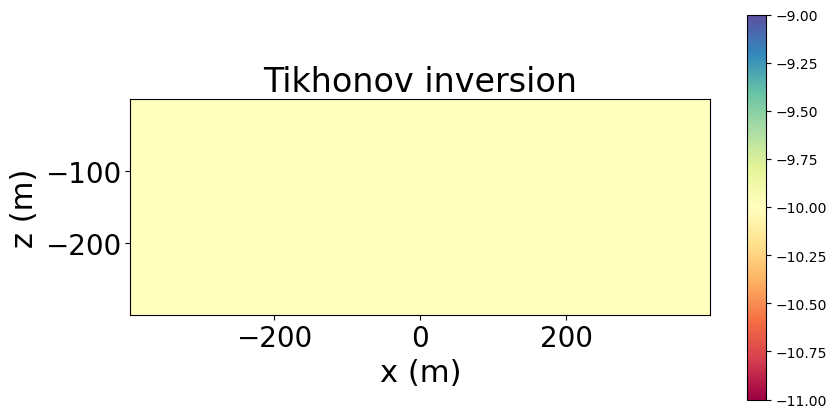

In [14]:
# Plot the recovered model
clim = [1, 500]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mopt, ax=ax, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
# ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)

In [13]:
mopt

array([-10., -10., -10., ..., -10., -10., -10.])